# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

In [43]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
from datetime import datetime, timedelta

# Time Series and Statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from itertools import product



In [44]:
%pip install numpy==1.26.4 scipy==1.11.4 scikit-learn==1.4.2 matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
# Machine Learning

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [46]:
print("✅ All libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All libraries imported successfully!
Analysis Date: 2025-12-16 13:04:21


# ============================================================================
# 2. DATA COLLECTION
# ============================================================================


In [47]:
%pip uninstall -y yfinance
%pip install --upgrade yfinance curl_cffi requests


Found existing installation: yfinance 0.2.66
Uninstalling yfinance-0.2.66:
  Successfully uninstalled yfinance-0.2.66
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [48]:
%pip install pandas-datareader


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime

STOCKS = {
    "AAPL": "aapl.us",
    "MSFT": "msft.us",
    "GOOGL": "googl.us",
    "AMZN": "amzn.us",
    "TSLA": "tsla.us"
}

START_DATE = "2020-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

stock_data = {}

print(f"📊 Loading stock data from {START_DATE} to {END_DATE}\n")

for name, ticker in STOCKS.items():
    try:
        df = pdr.DataReader(
            ticker,
            data_source="stooq",
            start=START_DATE,
            end=END_DATE
        )

        if df is not None and not df.empty:
            df = df.sort_index()
            df.reset_index(inplace=True)
            df["Ticker"] = name
            stock_data[name] = df
            print(f"✓ {name}: {len(df)} rows loaded from Stooq")
        else:
            print(f"✗ {name}: No data")

    except Exception as e:
        print(f"✗ {name}: {e}")

print(f"\n✅ Successfully loaded data for {len(stock_data)} stocks")


📊 Loading stock data from 2020-01-01 to 2025-12-16

✓ AAPL: 1497 rows loaded from Stooq
✓ MSFT: 1497 rows loaded from Stooq
✓ GOOGL: 1497 rows loaded from Stooq
✓ AMZN: 1497 rows loaded from Stooq
✓ TSLA: 1497 rows loaded from Stooq

✅ Successfully loaded data for 5 stocks


In [50]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime

STOCKS = {
    "AAPL": "aapl.us",
    "MSFT": "msft.us",
    "GOOGL": "googl.us",
    "AMZN": "amzn.us",
    "TSLA": "tsla.us"
}

START_DATE = "2020-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

stock_data = {}

print(f"📊 Loading stock data from {START_DATE} to {END_DATE}\n")

for name, ticker in STOCKS.items():
    try:
        df = pdr.DataReader(
            ticker,
            "stooq",
            start=START_DATE,
            end=END_DATE
        )

        if df is None or df.empty:
            print(f"✗ {name}: No data returned")
            continue

        # Stooq returns newest first → fix order
        df = df.sort_index()

        df.reset_index(inplace=True)
        df.rename(columns={
            "Date": "date",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        }, inplace=True)

        df["ticker"] = name
        stock_data[name] = df

        print(f"✓ {name}: {len(df)} rows loaded")

    except Exception as e:
        print(f"✗ {name}: {e}")

print(f"\n✅ Successfully loaded data for {len(stock_data)} stocks")


📊 Loading stock data from 2020-01-01 to 2025-12-16

✓ AAPL: 1497 rows loaded
✓ MSFT: 1497 rows loaded
✓ GOOGL: 1497 rows loaded
✓ AMZN: 1497 rows loaded
✓ TSLA: 1497 rows loaded

✅ Successfully loaded data for 5 stocks


In [51]:
stock_data["AAPL"].head()


,date,open,high,low,close,volume,ticker
0,2020-01-02,71.7196,72.7764,71.4646,72.7161,140071218,AAPL
1,2020-01-03,71.9425,72.7725,71.7839,72.0115,151314357,AAPL
2,2020-01-06,71.1246,72.6207,70.8782,72.5811,122445682,AAPL
3,2020-01-07,72.5909,72.8502,72.0233,72.2432,115147229,AAPL
4,2020-01-08,71.9444,73.7056,71.9425,73.4042,136680453,AAPL


In [52]:
df.head()

,date,open,high,low,close,volume,ticker
0,2020-01-02,28.3000,28.7130,28.1140,28.6840,143375790,TSLA
1,2020-01-03,29.3667,30.2667,29.1280,29.5340,266920455,TSLA
2,2020-01-06,29.3647,30.1040,29.3333,30.1027,152362485,TSLA
3,2020-01-07,30.7600,31.4420,30.2237,31.2707,273137070,TSLA
4,2020-01-08,31.5800,33.2333,31.2153,32.8093,467990895,TSLA


# ============================================================================
# 3. DATA PREPARATION AND CLEANING
# ============================================================================


In [53]:
import pandas as pd

def clean_stock_data(df, ticker):
    """
    Clean stock data: handle missing values, outliers, and format properly
    """
    df = df.copy()

    print(f"\n--- Cleaning {ticker} ---")
    print(f"Original shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")

    # Ensure datetime index
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)

    # Sort by date
    df = df.sort_index()

    # Handle missing values
    df = df.ffill(limit=3)
    df = df.bfill(limit=3)
    df = df.dropna()

    # Outlier detection using returns
    df["returns"] = df["close"].pct_change()

    Q1 = df["returns"].quantile(0.01)
    Q3 = df["returns"].quantile(0.99)
    IQR = Q3 - Q1

    outliers = ((df["returns"] < (Q1 - 3 * IQR)) |
                (df["returns"] > (Q3 + 3 * IQR))).sum()

    print(f"Extreme outliers detected: {outliers}")

    # Drop temporary column
    df.drop(columns=["returns"], inplace=True)

    print(f"Cleaned shape: {df.shape}")
    print(f"Date range: {df.index.min()} → {df.index.max()}")

    return df


# Clean all stock data
cleaned_data = {}

for ticker, data in stock_data.items():
    cleaned_data[ticker] = clean_stock_data(data, ticker)

print("\n✅ Data cleaning completed!")



--- Cleaning AAPL ---
Original shape: (1497, 7)
Missing values:
date      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64
Extreme outliers detected: 0
Cleaned shape: (1497, 6)
Date range: 2020-01-02 00:00:00 → 2025-12-15 00:00:00

--- Cleaning MSFT ---
Original shape: (1497, 7)
Missing values:
date      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64
Extreme outliers detected: 0
Cleaned shape: (1497, 6)
Date range: 2020-01-02 00:00:00 → 2025-12-15 00:00:00

--- Cleaning GOOGL ---
Original shape: (1497, 7)
Missing values:
date      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64
Extreme outliers detected: 0
Cleaned shape: (1497, 6)
Date range: 2020-01-02 00:00:00 → 2025-12-15 00:00:00

--- Cleaning AMZN ---
Original shape: (1497, 7)
Missing values:
date      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64
Extreme outliers detected: 

In [54]:
cleaned_data["AAPL"].head()


,open,high,low,close,volume,ticker
date,,,,,,
2020-01-02,71.7196,72.7764,71.4646,72.7161,140071218,AAPL
2020-01-03,71.9425,72.7725,71.7839,72.0115,151314357,AAPL
2020-01-06,71.1246,72.6207,70.8782,72.5811,122445682,AAPL
2020-01-07,72.5909,72.8502,72.0233,72.2432,115147229,AAPL
2020-01-08,71.9444,73.7056,71.9425,73.4042,136680453,AAPL


# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================



EXPLORATORY DATA ANALYSIS (EDA)

Analyzing AAPL in detail...

Dataset Statistics:
              open         high          low        close        volume
count  1497.000000  1497.000000  1497.000000  1497.000000  1.497000e+03
mean    164.493243   166.347021   162.799881   164.656895  8.626329e+07
std      49.058561    49.406016    48.757572    49.107275  5.299046e+07
min      55.347500    55.451100    51.596800    54.450700  2.013562e+07
25%     132.067000   133.053000   130.412000   131.732000  5.124725e+07
50%     163.540000   165.188000   162.184000   163.579000  7.128226e+07
75%     195.725000   198.390000   193.667000   196.250000  1.022193e+08
max     286.200000   288.620000   283.300000   286.190000  4.397629e+08


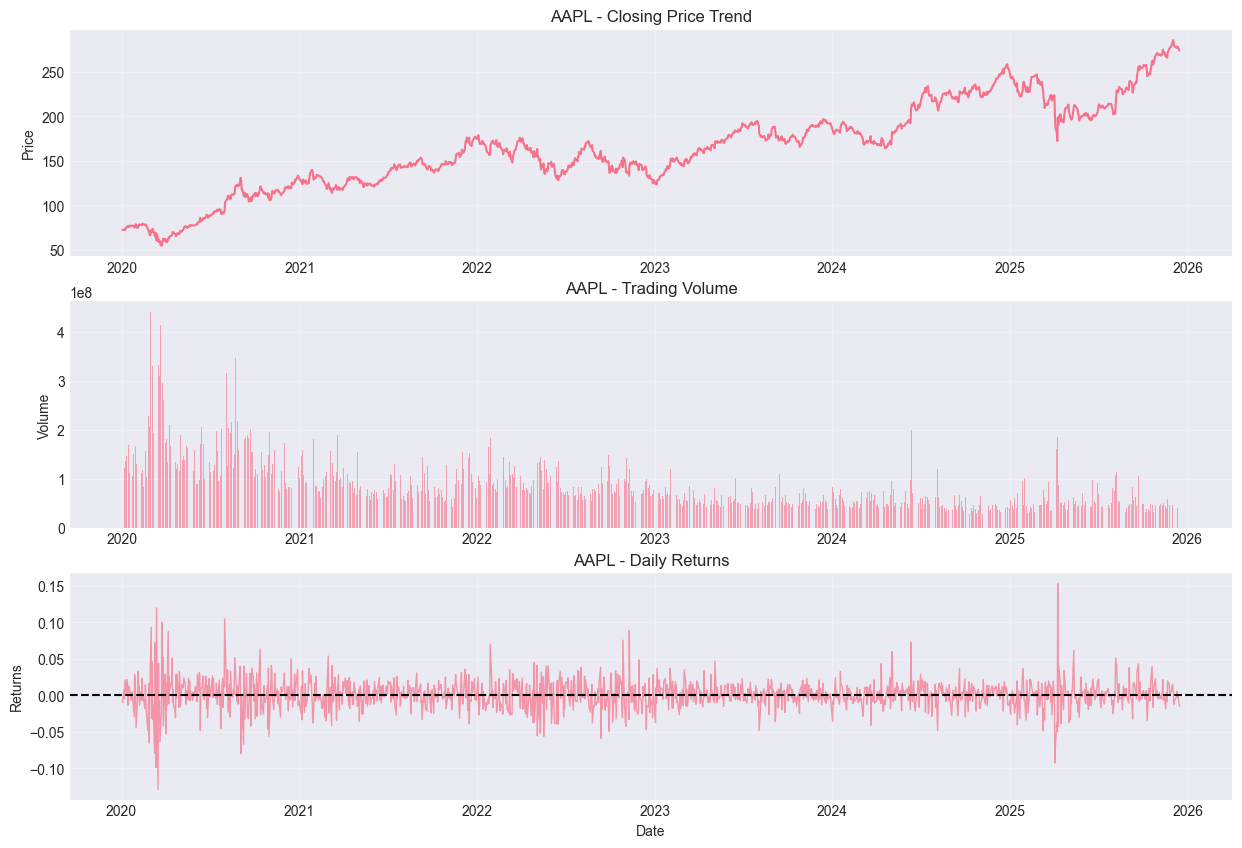

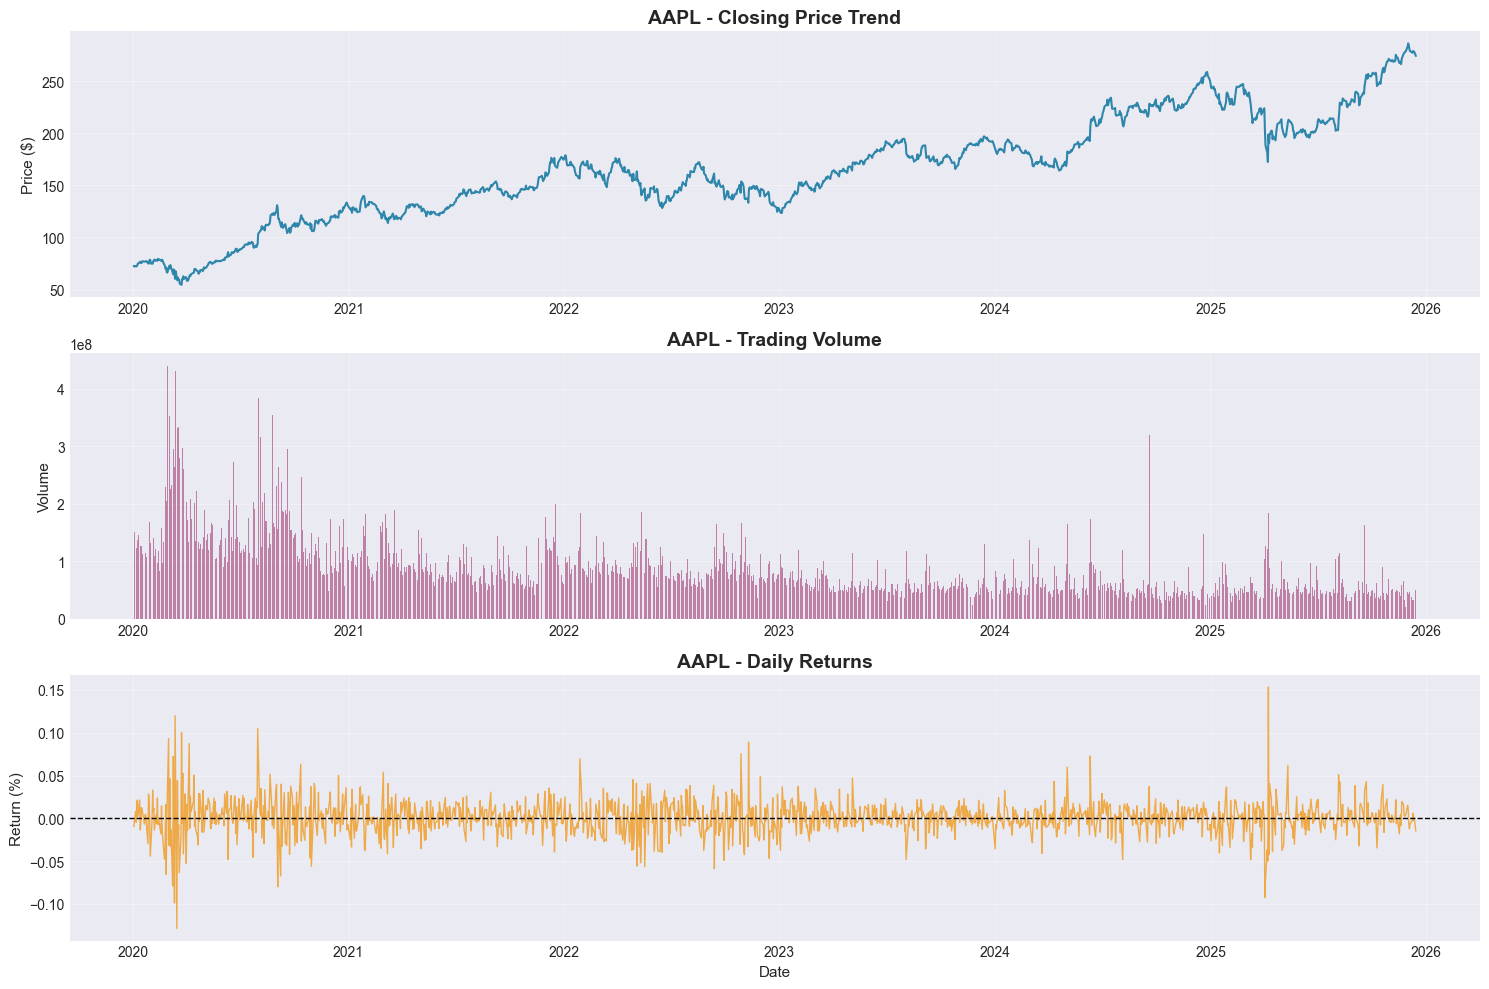

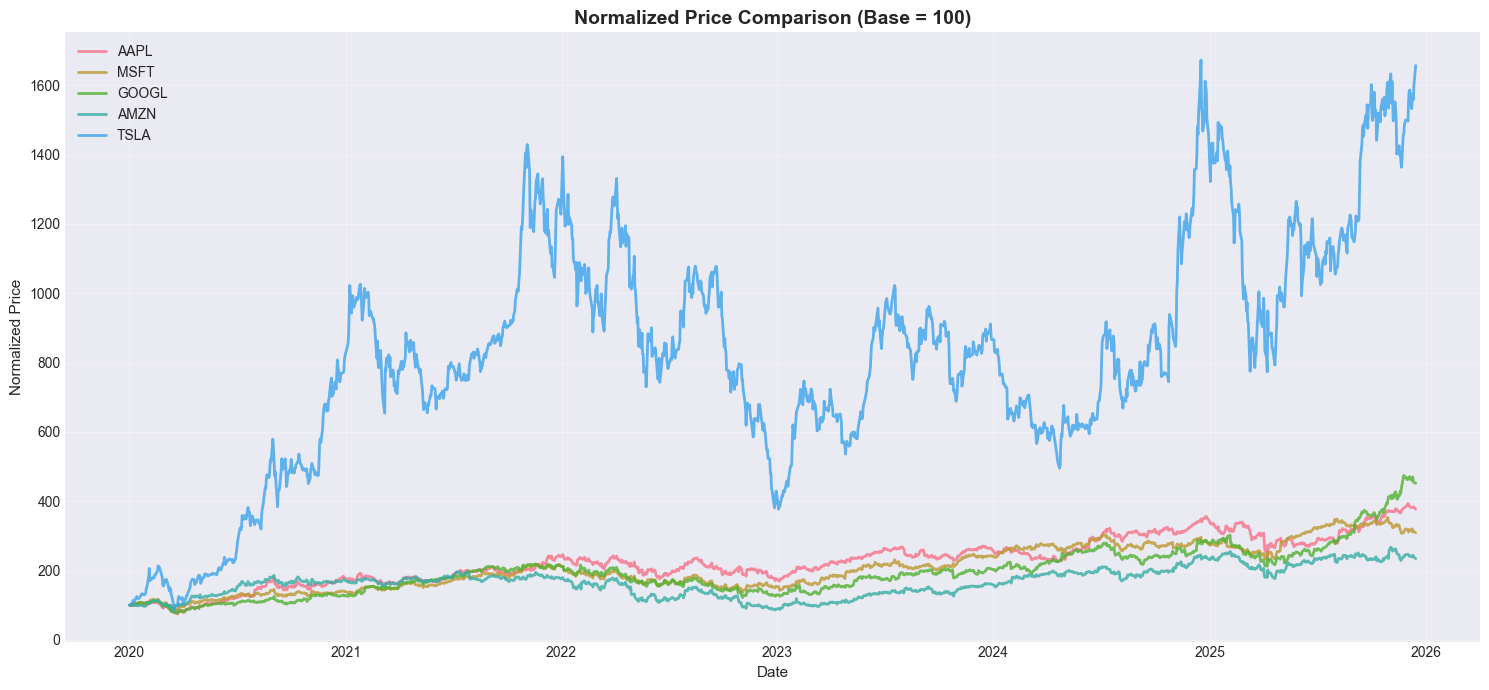

<Figure size 640x480 with 0 Axes>

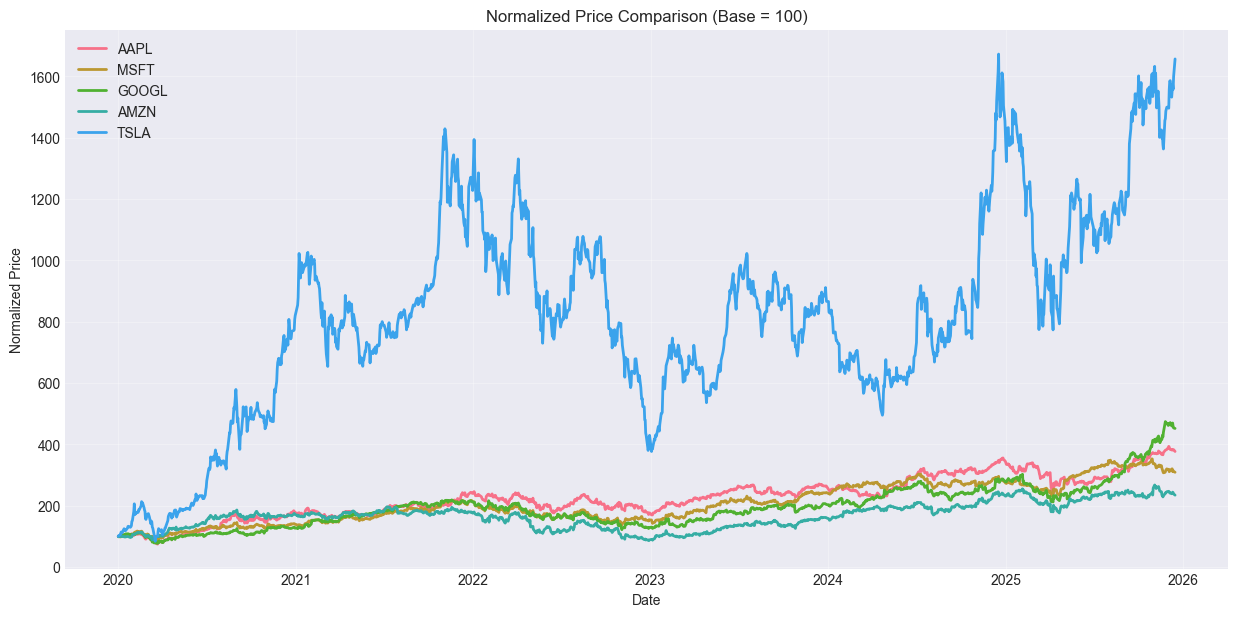

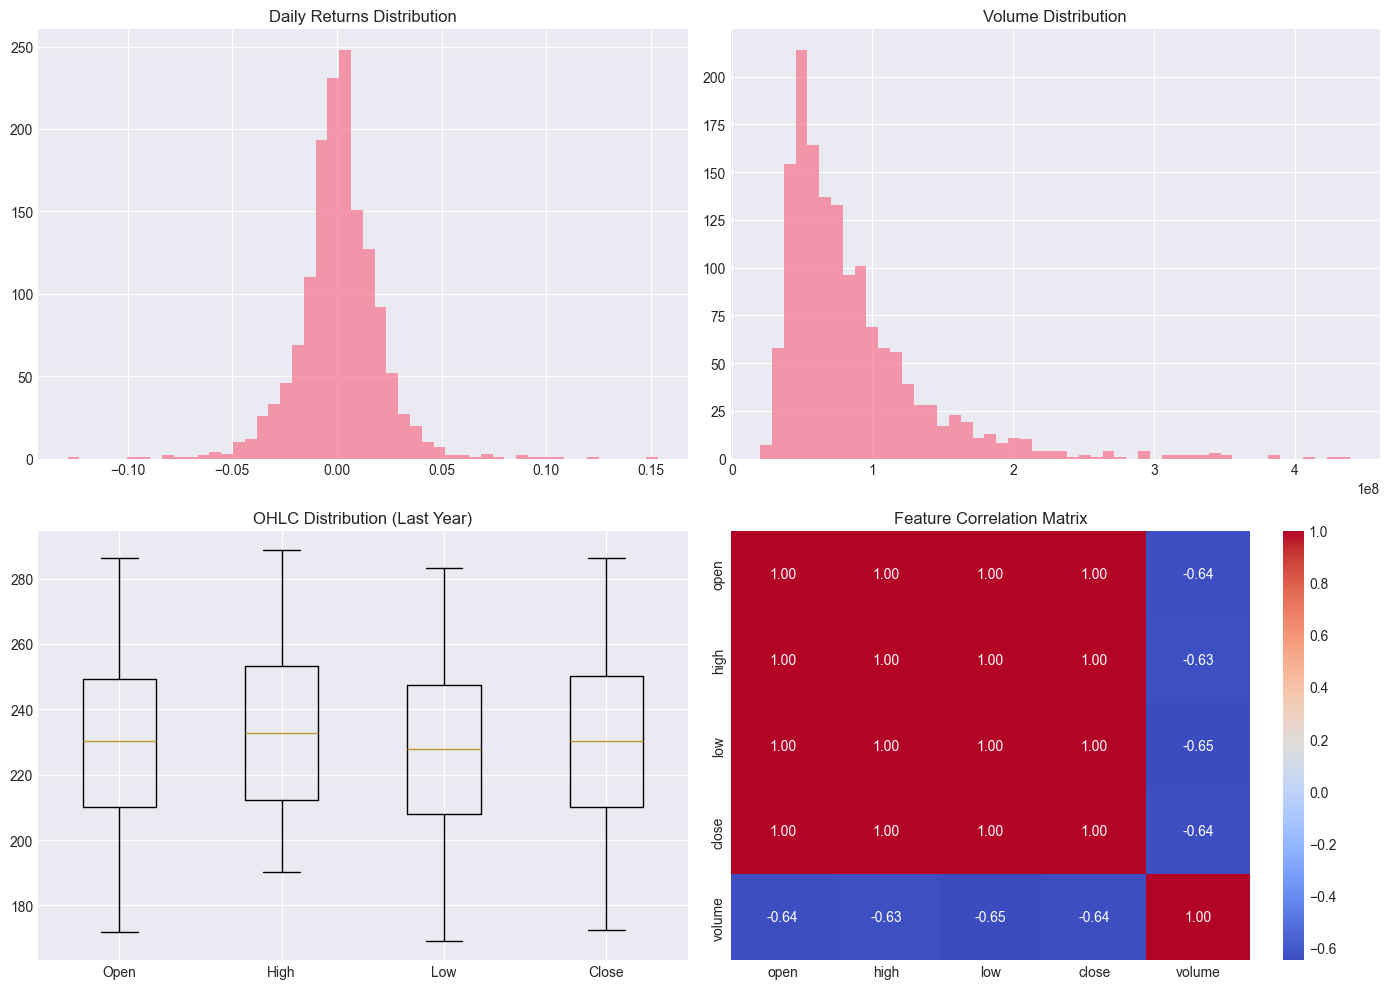

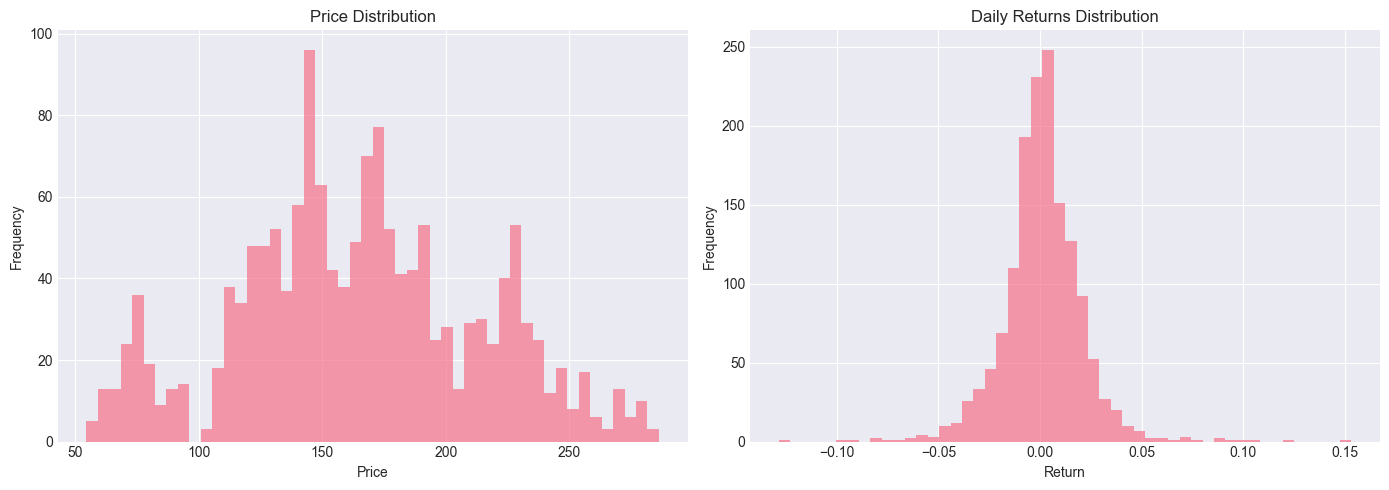


📈 Key Statistics for AAPL
• Trading days: 1497
• Avg daily return: 0.109%
• Volatility: 2.010%
• Sharpe (approx): 0.86
• Max drawdown: -33.36%
• Price range: 54.45 – 286.19


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

PRIMARY_STOCK = "AAPL"
df = cleaned_data[PRIMARY_STOCK].copy()

print(f"\nAnalyzing {PRIMARY_STOCK} in detail...")
print("\nDataset Statistics:")
print(df.describe())

# =========================
# 4.1 Price, Volume & Returns Trends
# =========================
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Closing price
axes[0].plot(df.index, df["close"], linewidth=1.5)
axes[0].set_title(f"{PRIMARY_STOCK} - Closing Price Trend")
axes[0].set_ylabel("Price")
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(df.index, df["volume"], alpha=0.6)
axes[1].set_title(f"{PRIMARY_STOCK} - Trading Volume")
axes[1].set_ylabel("Volume")
axes[1].grid(True, alpha=0.3)

# Daily returns
returns = df["close"].pct_change()
axes[2].plot(df.index, returns, linewidth=1, alpha=0.7)
axes[2].axhline(0, linestyle="--", color="black")
axes[2].set_title(f"{PRIMARY_STOCK} - Daily Returns")
axes[2].set_ylabel("Returns")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3)

# ==========================================

# Price and Volume Trends
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Closing price trend
axes[0].plot(df.index, df['close'], linewidth=1.5, color='#2E86AB')
axes[0].set_title(f'{PRIMARY_STOCK} - Closing Price Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Volume trend
axes[1].bar(df.index, df['volume'], color='#A23B72', alpha=0.6, width=1)
axes[1].set_title(f'{PRIMARY_STOCK} - Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Daily returns
returns = df['close'].pct_change()
axes[2].plot(df.index, returns, linewidth=1, color='#F18F01', alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_title(f'{PRIMARY_STOCK} - Daily Returns', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Return (%)', fontsize=11)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PRIMARY_STOCK}_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================

# Multiple stocks comparison
fig, ax = plt.subplots(figsize=(15, 7))

for ticker in list(cleaned_data.keys())[:6]:  # First 6 stocks
    normalized = (cleaned_data[ticker]['close'] / cleaned_data[ticker]['close'].iloc[0]) * 100
    ax.plot(normalized.index, normalized, label=ticker, linewidth=2, alpha=0.8)

ax.set_title('Normalized Price Comparison (Base = 100)', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized Price', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('multi_stock_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =======================================================================

plt.tight_layout()
plt.show()

# =========================
# 4.2 Multi-stock Comparison
# =========================
fig, ax = plt.subplots(figsize=(15, 7))

for ticker in cleaned_data.keys():
    norm_price = (
        cleaned_data[ticker]["close"]
        / cleaned_data[ticker]["close"].iloc[0]
        * 100
    )
    ax.plot(norm_price.index, norm_price, label=ticker, linewidth=2)

ax.set_title("Normalized Price Comparison (Base = 100)")
ax.set_ylabel("Normalized Price")
ax.set_xlabel("Date")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# =========================
# 4.3 Distribution Analysis (ADDED)
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns distribution
axes[0, 0].hist(returns.dropna(), bins=50, alpha=0.7)
axes[0, 0].set_title("Daily Returns Distribution")

# Volume distribution
axes[0, 1].hist(df["volume"], bins=50, alpha=0.7)
axes[0, 1].set_title("Volume Distribution")

# OHLC boxplot (last year)
ohlc = df[["open", "high", "low", "close"]].iloc[-252:]
axes[1, 0].boxplot(
    [ohlc[c] for c in ohlc.columns],
    labels=["Open", "High", "Low", "Close"]
)
axes[1, 0].set_title("OHLC Distribution (Last Year)")

# Correlation heatmap
corr = df[["open", "high", "low", "close", "volume"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Feature Correlation Matrix")

plt.tight_layout()
plt.show()

# =========================
# 4.4 Price & Returns Distribution (FINAL ADDITION)
# =========================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution
axes[0].hist(df["close"], bins=50, alpha=0.7)
axes[0].set_title("Price Distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Returns distribution
axes[1].hist(returns.dropna(), bins=50, alpha=0.7)
axes[1].set_title("Daily Returns Distribution")
axes[1].set_xlabel("Return")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_distributions.png", dpi=300)
plt.show()

# =========================
# Key Statistics
# =========================
print(f"\n📈 Key Statistics for {PRIMARY_STOCK}")
print(f"• Trading days: {len(df)}")
print(f"• Avg daily return: {returns.mean()*100:.3f}%")
print(f"• Volatility: {returns.std()*100:.3f}%")
print(f"• Sharpe (approx): {(returns.mean()/returns.std())*np.sqrt(252):.2f}")
print(f"• Max drawdown: {((df['close']/df['close'].cummax())-1).min()*100:.2f}%")
print(f"• Price range: {df['close'].min():.2f} – {df['close'].max():.2f}")


# ============================================================================
# 5. FEATURE ENGINEERING
# ============================================================================


FEATURE ENGINEERING

Creating features for AAPL...
✓ Total features created: 57


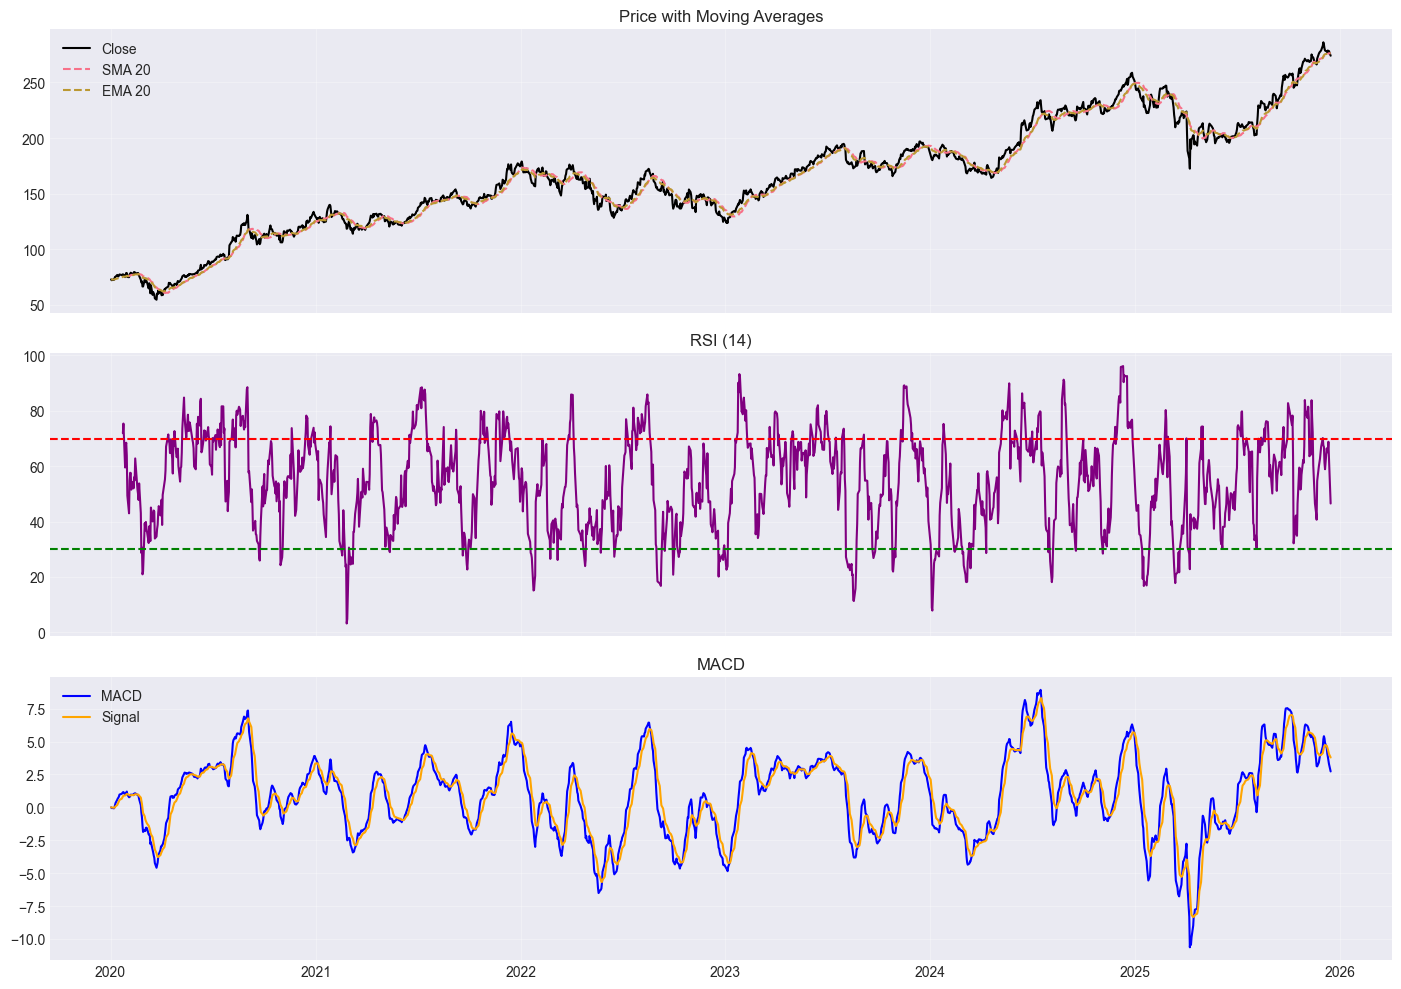

In [56]:
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# =========================
# Indicator Functions
# =========================
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.clip(lower=0).rolling(period).mean()
    loss = -delta.clip(upper=0).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# =========================
# Feature Creation
# =========================
def create_features(df, lags=[1,2,3,5,10], windows=[5,10,20,50]):
    df = df.copy()

    # -----------------------
    # Price-based features
    # -----------------------
    df["returns"] = df["close"].pct_change()
    df["log_returns"] = np.log(df["close"] / df["close"].shift(1))
    df["range"] = (df["high"] - df["low"]) / df["close"]
    df["gap"] = (df["open"] - df["close"].shift(1)) / df["close"].shift(1)

    # -----------------------
    # Lag features
    # -----------------------
    for lag in lags:
        df[f"close_lag_{lag}"] = df["close"].shift(lag)
        df[f"returns_lag_{lag}"] = df["returns"].shift(lag)
        df[f"volume_lag_{lag}"] = df["volume"].shift(lag)

    # -----------------------
    # Rolling statistics
    # -----------------------
    for w in windows:
        df[f"sma_{w}"] = df["close"].rolling(w).mean()
        df[f"ema_{w}"] = df["close"].ewm(span=w, adjust=False).mean()
        df[f"volatility_{w}"] = df["returns"].rolling(w).std()
        df[f"volume_sma_{w}"] = df["volume"].rolling(w).mean()
        df[f"price_to_sma_{w}"] = df["close"] / df[f"sma_{w}"]

    # -----------------------
    # Technical indicators
    # -----------------------
    df["rsi_14"] = calculate_rsi(df["close"])
    df["macd"], df["macd_signal"] = calculate_macd(df["close"])
    df["macd_diff"] = df["macd"] - df["macd_signal"]

    # Bollinger Bands
    bb_mid = df["close"].rolling(20).mean()
    bb_std = df["close"].rolling(20).std()
    df["bb_upper"] = bb_mid + 2 * bb_std
    df["bb_lower"] = bb_mid - 2 * bb_std
    df["bb_width"] = (df["bb_upper"] - df["bb_lower"]) / bb_mid
    df["bb_position"] = (df["close"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])

    # -----------------------
    # Time features
    # -----------------------
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter

    # -----------------------
    # Target variable
    # -----------------------
    df["target"] = df["close"].shift(-1)

    return df

print(f"\nCreating features for {PRIMARY_STOCK}...")
df_features = create_features(df)

print(f"✓ Total features created: {df_features.shape[1]}")

# =========================
# Technical Indicators Visualization (NEW)
# =========================
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Close + Moving Averages
axes[0].plot(df_features.index, df_features["close"], label="Close", color="black")
axes[0].plot(df_features.index, df_features["sma_20"], label="SMA 20", linestyle="--")
axes[0].plot(df_features.index, df_features["ema_20"], label="EMA 20", linestyle="--")
axes[0].set_title("Price with Moving Averages")
axes[0].legend()
axes[0].grid(alpha=0.3)

# RSI
axes[1].plot(df_features.index, df_features["rsi_14"], color="purple")
axes[1].axhline(70, color="red", linestyle="--")
axes[1].axhline(30, color="green", linestyle="--")
axes[1].set_title("RSI (14)")
axes[1].grid(alpha=0.3)

# MACD
axes[2].plot(df_features.index, df_features["macd"], label="MACD", color="blue")
axes[2].plot(df_features.index, df_features["macd_signal"], label="Signal", color="orange")
axes[2].set_title("MACD")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_technical_indicators.png", dpi=300)
plt.show()


# ============================================================================
# 6. ARIMA MODEL
# ============================================================================


ARIMA MODEL DEVELOPMENT

Original Series - Stationarity Test
ADF Statistic: -0.876886
p-value: 0.795489
Critical Values:
  1%: -3.435
  5%: -2.863
  10%: -2.568
✗ Series is non-stationary (fail to reject H0)

First Differenced Series - Stationarity Test
ADF Statistic: -37.903961
p-value: 0.000000
Critical Values:
  1%: -3.435
  5%: -2.863
  10%: -2.568
✓ Series is stationary (reject H0)


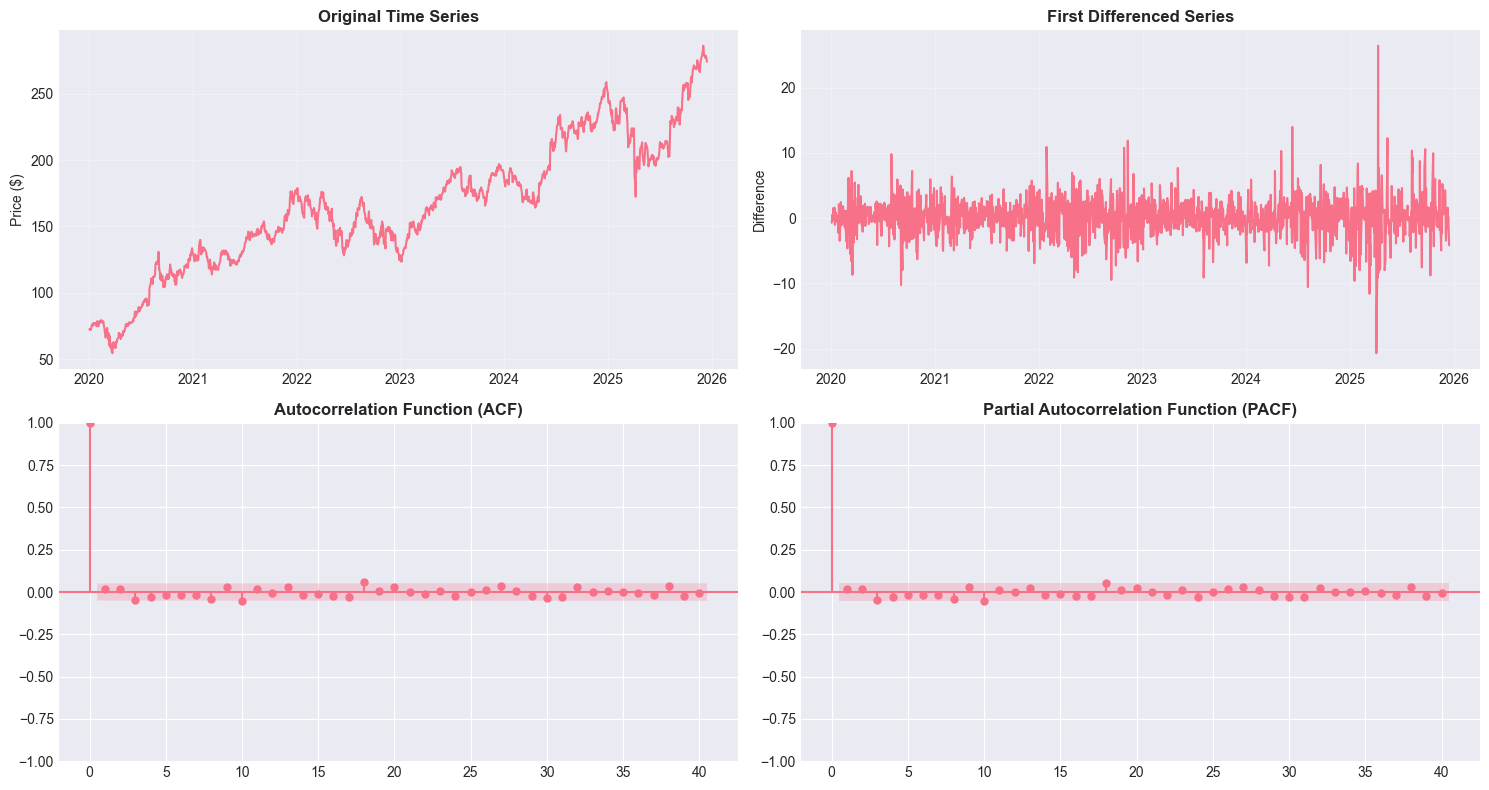

✓ ACF/PACF plots saved: AAPL_acf_pacf.png

🔍 Finding optimal ARIMA parameters...
Training size: 1197, Test size: 300

Top 10 ARIMA models by AIC:
 p  d  q         AIC
 2  2  3 5744.457023
 2  1  5 5745.805959
 4  2  3 5746.250725
 2  2  5 5746.279593
 2  2  4 5746.396093
 3  2  3 5746.401690
 0  1  0 5746.402590
 5  1  2 5746.831788
 4  1  4 5747.355727
 5  1  3 5747.867926

✓ Best ARIMA parameters: (2, 2, 3)
  AIC: 5744.46

Fitting ARIMA(2, 2, 3) on training data...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1197
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -2866.229
Date:                Tue, 16 Dec 2025   AIC                           5744.457
Time:                        13:07:48   BIC                           5774.972
Sample:                             0   HQIC                          5755.954
                               - 1197 

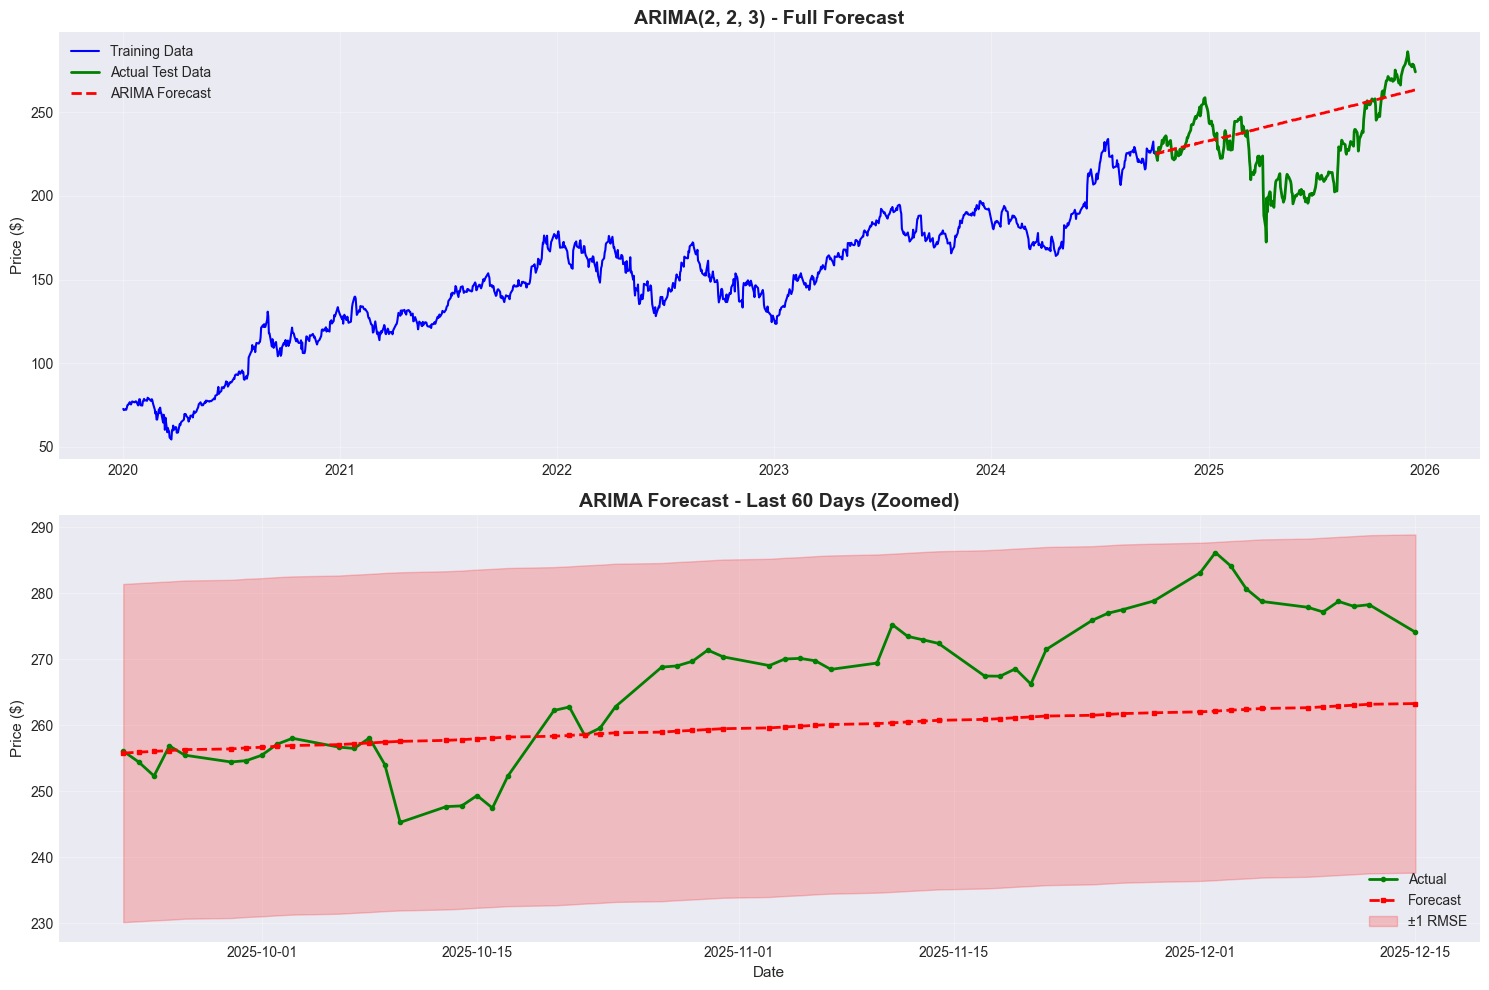

✓ ARIMA forecast chart saved: AAPL_arima_forecast.png


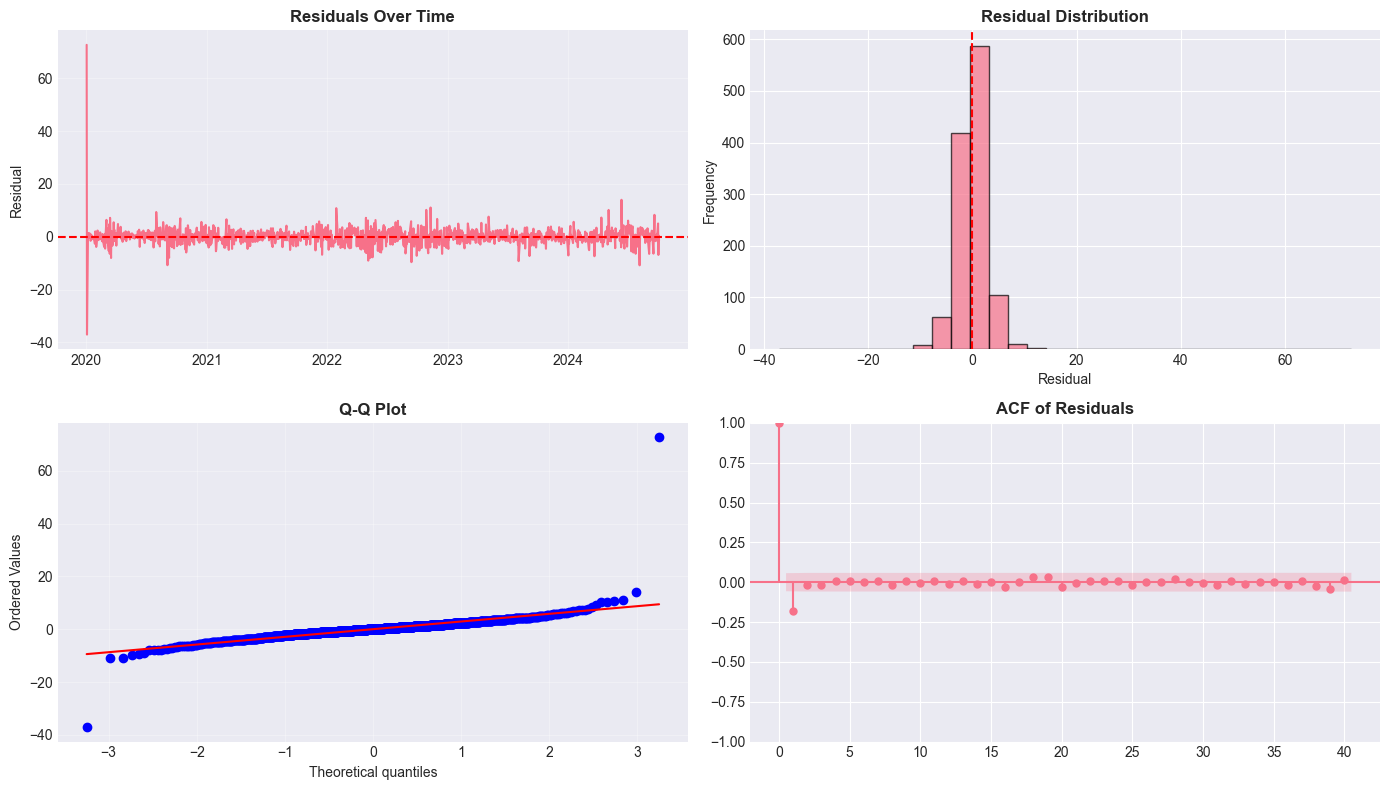

✓ ARIMA residuals analysis saved: AAPL_arima_residuals.png


In [57]:
print("\n" + "="*70)
print("ARIMA MODEL DEVELOPMENT")
print("="*70)

# Prepare data for ARIMA
close_prices = df['close'].copy()

# Test for stationarity
def test_stationarity(timeseries, title=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna())
    print(f'\n{title}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✓ Series is stationary (reject H0)")
        return True
    else:
        print("✗ Series is non-stationary (fail to reject H0)")
        return False

# Check stationarity of original series
is_stationary = test_stationarity(close_prices, 'Original Series - Stationarity Test')

# Make series stationary through differencing
close_diff = close_prices.diff().dropna()
test_stationarity(close_diff, 'First Differenced Series - Stationarity Test')

# Plot ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Original series
axes[0, 0].plot(close_prices.index, close_prices.values)
axes[0, 0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Price ($)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Differenced series
axes[0, 1].plot(close_diff.index, close_diff.values)
axes[0, 1].set_title('First Differenced Series', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Difference', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# ACF plot
plot_acf(close_diff, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# PACF plot
plot_pacf(close_diff, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PRIMARY_STOCK}_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ACF/PACF plots saved: {PRIMARY_STOCK}_acf_pacf.png")

# Grid search for optimal ARIMA parameters
print("\n🔍 Finding optimal ARIMA parameters...")

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_aic = np.inf
best_params = None
best_model = None

# Use last 80% for training, 20% for testing
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"Training size: {len(train)}, Test size: {len(test)}")

results_list = []

for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted_model = model.fit()
        aic = fitted_model.aic
        results_list.append({'p': p, 'd': d, 'q': q, 'AIC': aic})
        
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
            best_model = fitted_model
    except:
        continue

# Show top 5 models
results_df = pd.DataFrame(results_list).sort_values('AIC').head(10)
print("\nTop 10 ARIMA models by AIC:")
print(results_df.to_string(index=False))

print(f"\n✓ Best ARIMA parameters: {best_params}")
print(f"  AIC: {best_aic:.2f}")

# Fit the best model and forecast
print(f"\nFitting ARIMA{best_params} on training data...")
arima_model = ARIMA(train, order=best_params)
arima_fitted = arima_model.fit()

print("\nModel Summary:")
print(arima_fitted.summary())

# Make predictions
forecast_steps = len(test)
forecast = arima_fitted.forecast(steps=forecast_steps)

# Calculate ARIMA metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"  RMSE: ${rmse:.4f}")
    print(f"  MAE:  ${mae:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

arima_metrics = calculate_metrics(test.values, forecast.values, f'ARIMA{best_params}')

# Plot ARIMA results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full forecast
axes[0].plot(train.index, train.values, label='Training Data', color='blue', linewidth=1.5)
axes[0].plot(test.index, test.values, label='Actual Test Data', color='green', linewidth=2)
axes[0].plot(test.index, forecast.values, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
axes[0].set_title(f'ARIMA{best_params} - Full Forecast', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Zoomed forecast (last 60 days)
zoom_start = max(0, len(test) - 60)
axes[1].plot(test.index[zoom_start:], test.values[zoom_start:], label='Actual', color='green', linewidth=2, marker='o', markersize=3)
axes[1].plot(test.index[zoom_start:], forecast.values[zoom_start:], label='Forecast', color='red', linewidth=2, marker='s', markersize=3, linestyle='--')
axes[1].fill_between(test.index[zoom_start:], 
                       forecast.values[zoom_start:] - arima_metrics['RMSE'], 
                       forecast.values[zoom_start:] + arima_metrics['RMSE'], 
                       alpha=0.2, color='red', label='±1 RMSE')
axes[1].set_title('ARIMA Forecast - Last 60 Days (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price ($)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PRIMARY_STOCK}_arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ARIMA forecast chart saved: {PRIMARY_STOCK}_arima_forecast.png")

# Residual analysis
residuals = arima_fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual', fontsize=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].grid(True, alpha=0.3)

# Residual distribution
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].axvline(x=0, color='r', linestyle='--')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PRIMARY_STOCK}_arima_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ARIMA residuals analysis saved: {PRIMARY_STOCK}_arima_residuals.png")

# ============================================================================
# 7. GRADIENT BOOSTING MODEL
# ============================================================================


GRADIENT BOOSTING MODEL DEVELOPMENT

Dataset prepared:
  Samples : 1446
  Features: 55
  Training samples: 1156
  Testing samples : 290

🔧 Training baseline Gradient Boosting model...

📊 Baseline Metrics
  RMSE: 19.8763
  MAE : 13.8905

🔍 Hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✓ Best parameters:
  learning_rate: 0.05
  max_depth: 3
  n_estimators: 100
  subsample: 0.8

🚀 Training optimized Gradient Boosting model...

📈 Optimized Model Metrics
  RMSE: 20.0164
  MAE : 13.5746
  MAPE: 5.43%

📊 Top 10 Important Features:
    feature  importance
      close    0.605141
        low    0.203804
       high    0.060453
     ema_50    0.028465
close_lag_2    0.017601
     sma_50    0.016847
close_lag_1    0.014719
       open    0.012787
     ema_20    0.010034
      sma_5    0.009341


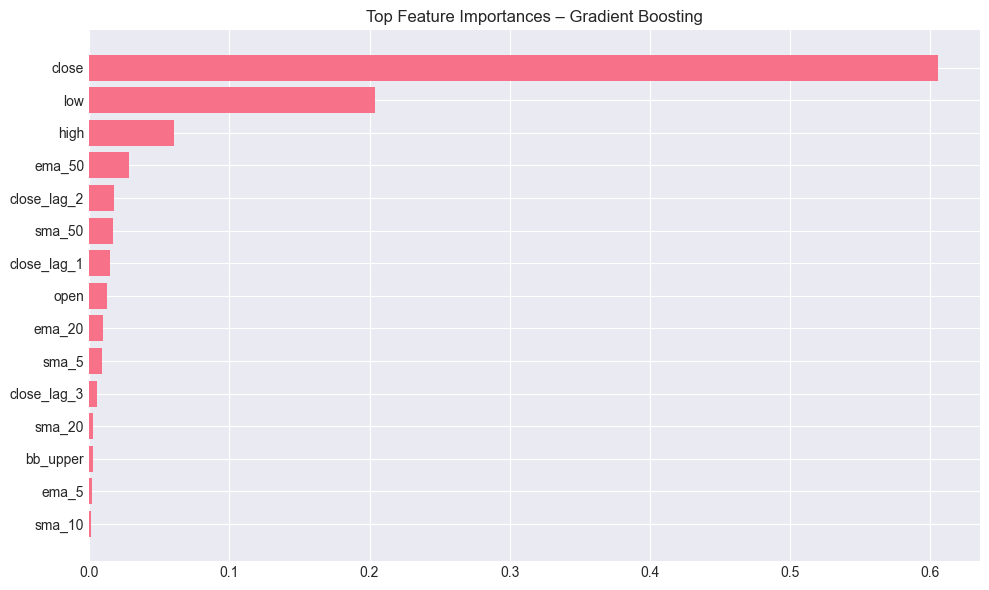

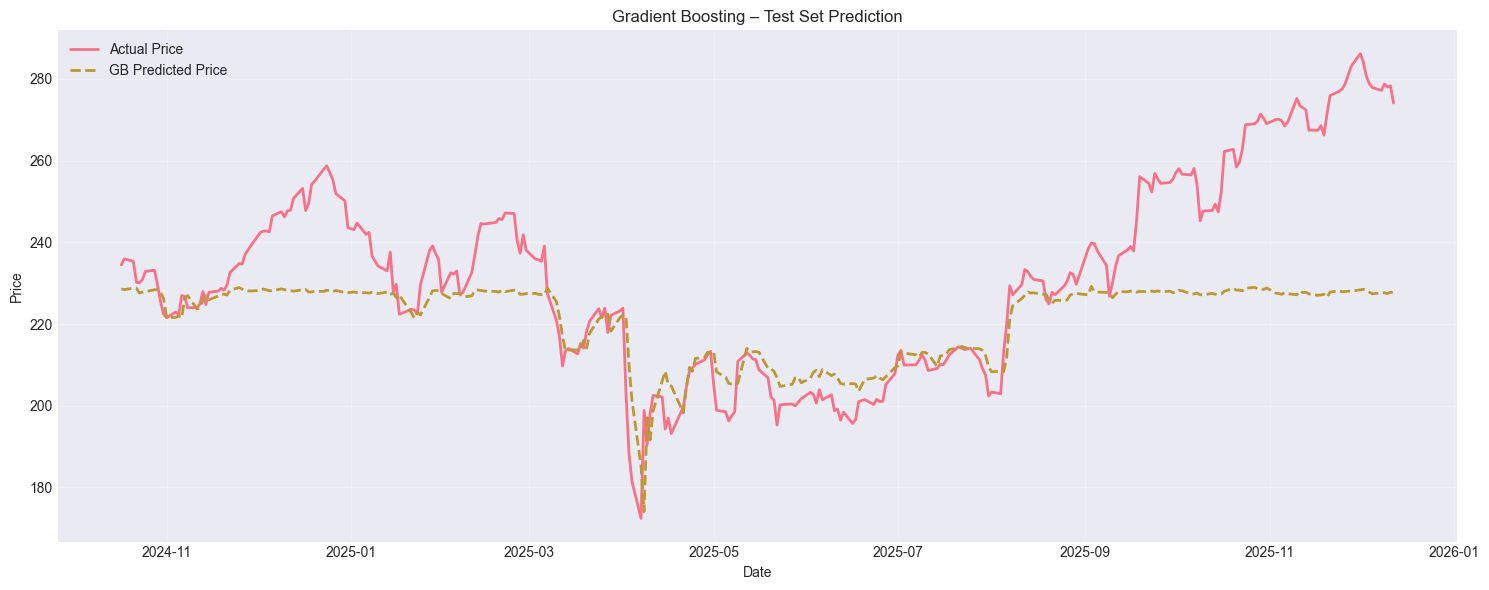

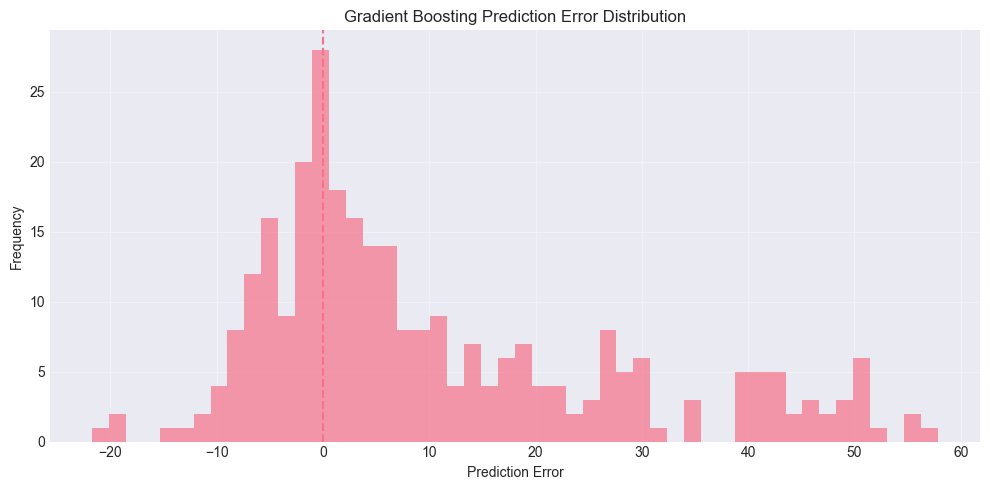


✅ Gradient Boosting model + error analysis completed successfully


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n" + "="*70)
print("GRADIENT BOOSTING MODEL DEVELOPMENT")
print("="*70)

# -------------------------------------------------
# Prepare ML dataset
# -------------------------------------------------
df_ml = df_features.dropna().copy()

# Keep ONLY numeric columns
X = df_ml.select_dtypes(include=[np.number]).copy()

# Target variable
y = X.pop("target")

print("\nDataset prepared:")
print(f"  Samples : {X.shape[0]}")
print(f"  Features: {X.shape[1]}")

# -------------------------------------------------
# Time-based train-test split (80/20)
# -------------------------------------------------
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples : {len(X_test)}")

# -------------------------------------------------
# Feature scaling
# -------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------------
# Baseline Gradient Boosting
# -------------------------------------------------
print("\n🔧 Training baseline Gradient Boosting model...")

gb_baseline = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_baseline.fit(X_train_scaled, y_train)
y_pred_base = gb_baseline.predict(X_test_scaled)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

print("\n📊 Baseline Metrics")
print(f"  RMSE: {rmse_base:.4f}")
print(f"  MAE : {mae_base:.4f}")

# -------------------------------------------------
# Hyperparameter tuning (SAFE MODE)
# -------------------------------------------------
print("\n🔍 Hyperparameter tuning with GridSearchCV...")

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=1,   # Python 3.12 + Windows safe
    verbose=1
)

grid.fit(X_train_scaled, y_train)

print("\n✓ Best parameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

# -------------------------------------------------
# Train final optimized model
# -------------------------------------------------
print("\n🚀 Training optimized Gradient Boosting model...")

gb_final = GradientBoostingRegressor(
    **grid.best_params_,
    random_state=42
)

gb_final.fit(X_train_scaled, y_train)
y_pred_final = gb_final.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)
mape = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print("\n📈 Optimized Model Metrics")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  MAPE: {mape:.2f}%")

# -------------------------------------------------
# Feature importance
# -------------------------------------------------
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": gb_final.feature_importances_
}).sort_values("importance", ascending=False)

print("\n📊 Top 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance.head(15)["feature"],
    feature_importance.head(15)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Top Feature Importances – Gradient Boosting")
plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_gb_feature_importance.png", dpi=300)
plt.show()

# -------------------------------------------------
# Prediction plot
# -------------------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(X_test.index, y_test, label="Actual Price", linewidth=2)
plt.plot(X_test.index, y_pred_final, label="GB Predicted Price", linestyle="--", linewidth=2)
plt.title("Gradient Boosting – Test Set Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_gb_predictions.png", dpi=300)
plt.show()

# -------------------------------------------------
# Error Distribution Analysis (NEW)
# -------------------------------------------------
errors = y_test.values - y_pred_final

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(0, linestyle="--")
plt.title("Gradient Boosting Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_gb_error_analysis.png", dpi=300)
plt.show()

print("\n✅ Gradient Boosting model + error analysis completed successfully")


# ============================================================================
# 8. MODEL COMPARISON
# ============================================================================


MODEL COMPARISON

📊 Model Performance Comparison:
            Model      RMSE       MAE     MAPE
            ARIMA 25.644289 19.941253 9.238918
Gradient Boosting 20.016383 13.574569 5.432697

🏆 Best Model (by RMSE): Gradient Boosting


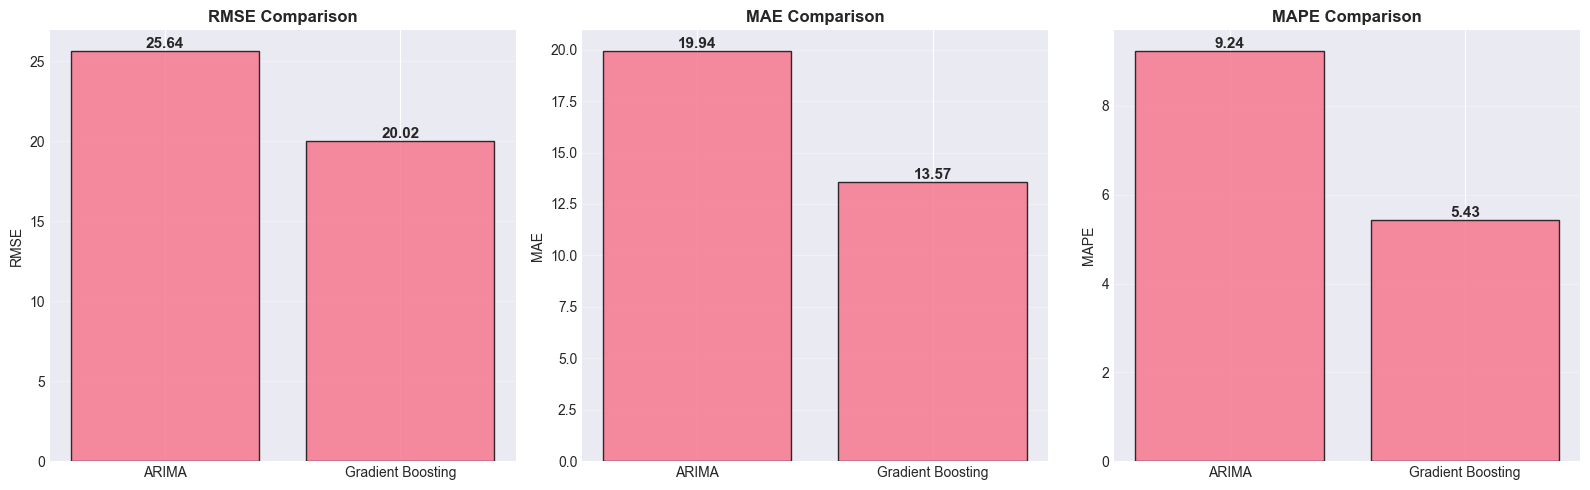

✓ Metric comparison saved: AAPL_model_comparison.png


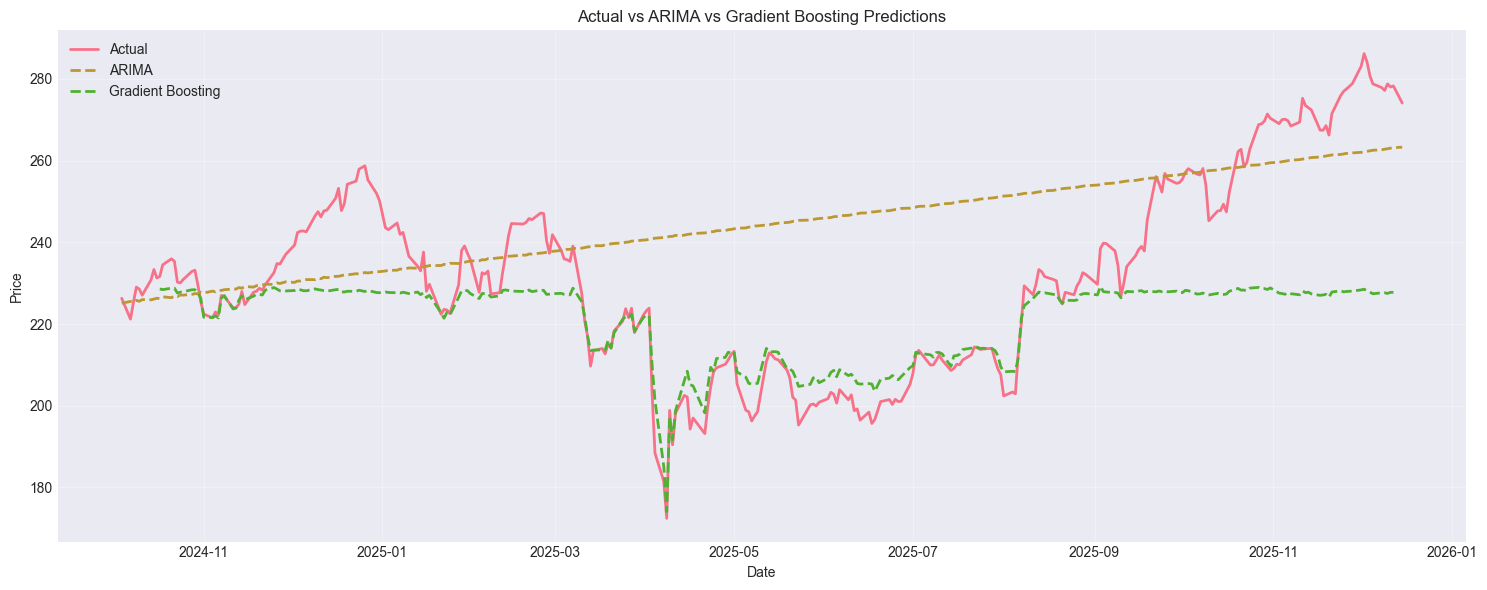

✓ Prediction comparison saved: AAPL_comparison_predictions.png


In [59]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# -------------------------------------------------
# Metrics Comparison (Safe Recreation)
# -------------------------------------------------
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "Gradient Boosting"],
    "RMSE": [arima_metrics["RMSE"], rmse],
    "MAE":  [arima_metrics["MAE"], mae],
    "MAPE": [arima_metrics["MAPE"], mape]
})

print("\n📊 Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Best model
best_model = comparison_df.loc[comparison_df["RMSE"].idxmin(), "Model"]
print(f"\n🏆 Best Model (by RMSE): {best_model}")

# -------------------------------------------------
# Metric Visualization
# -------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ["RMSE", "MAE", "MAPE"]

for i, metric in enumerate(metrics):
    bars = axes[i].bar(
        comparison_df["Model"],
        comparison_df[metric],
        edgecolor="black",
        alpha=0.8
    )

    axes[i].set_title(f"{metric} Comparison", fontweight="bold")
    axes[i].set_ylabel(metric)
    axes[i].grid(axis="y", alpha=0.3)

    # Value labels
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold"
        )

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Metric comparison saved: {PRIMARY_STOCK}_model_comparison.png")

# -------------------------------------------------
# Prediction Comparison Visualization (NEW)
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(test.index, test.values, label="Actual", linewidth=2)
ax.plot(test.index, forecast.values, label="ARIMA", linestyle="--", linewidth=2)
ax.plot(y_test.index, y_pred_final, label="Gradient Boosting", linestyle="--", linewidth=2)

ax.set_title("Actual vs ARIMA vs Gradient Boosting Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_comparison_predictions.png", dpi=300)
plt.show()

print(f"✓ Prediction comparison saved: {PRIMARY_STOCK}_comparison_predictions.png")


# ============================================================================
# 9. TRADING STRATEGY IMPLICATIONS
# ============================================================================


TRADING STRATEGY IMPLICATIONS

ARIMA Directional Accuracy: 52.51%
Gradient Boosting Directional Accuracy: 51.56%

💰 Strategy Results:
ARIMA Strategy Return       : 44.57%
Gradient Boosting Return   : 20.23%
Buy & Hold Return          : 21.13%


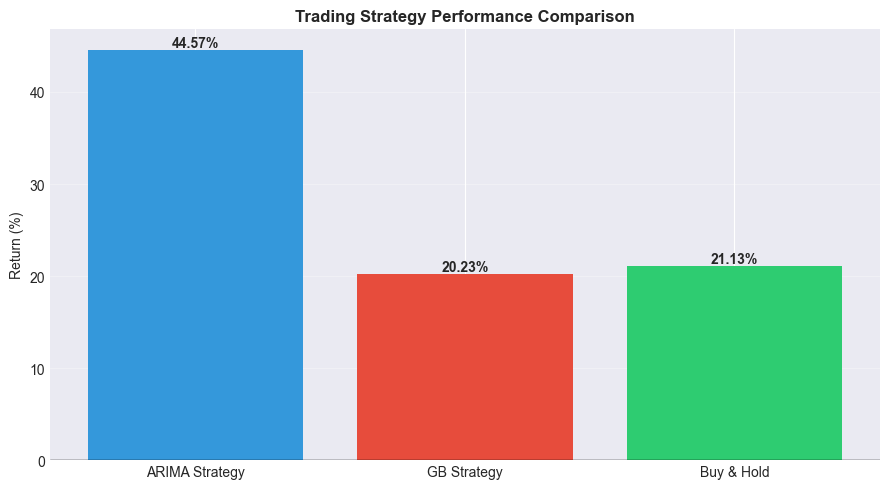


✓ Trading strategy chart saved: AAPL_trading_strategy.png


In [60]:
# ============================================================================
# 9. TRADING STRATEGY IMPLICATIONS (SAFE VERSION)
# ============================================================================

print("\n" + "="*70)
print("TRADING STRATEGY IMPLICATIONS")
print("="*70)

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Align arrays safely (CRITICAL FIX)
# -------------------------------------------------
arima_actual = test.values.flatten()
arima_pred = forecast.values.flatten()

gb_actual = y_test.values.flatten()
gb_pred = y_pred_final.flatten()

min_len_arima = min(len(arima_actual), len(arima_pred))
min_len_gb = min(len(gb_actual), len(gb_pred))

arima_actual = arima_actual[:min_len_arima]
arima_pred = arima_pred[:min_len_arima]

gb_actual = gb_actual[:min_len_gb]
gb_pred = gb_pred[:min_len_gb]

# -------------------------------------------------
# Directional Accuracy (SAFE)
# -------------------------------------------------
def directional_accuracy(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)

    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    min_len = min(len(actual_diff), len(pred_diff))
    if min_len == 0:
        return 0.0

    return (np.sign(actual_diff[:min_len]) == np.sign(pred_diff[:min_len])).mean() * 100

arima_dir_acc = directional_accuracy(arima_actual, arima_pred)
gb_dir_acc = directional_accuracy(gb_actual, gb_pred)

print(f"\nARIMA Directional Accuracy: {arima_dir_acc:.2f}%")
print(f"Gradient Boosting Directional Accuracy: {gb_dir_acc:.2f}%")

# -------------------------------------------------
# Trading Strategy Simulation (SAFE)
# -------------------------------------------------
def simulate_strategy(actual, predicted, capital=100000):
    cash = capital
    position = 0

    for i in range(1, len(predicted)):
        prev_price = actual[i - 1]
        if prev_price == 0:
            continue

        pred_return = (predicted[i] - prev_price) / prev_price
        actual_return = (actual[i] - prev_price) / prev_price

        if pred_return > 0.001 and position == 0:
            position = 1
        elif pred_return < -0.001 and position == 1:
            position = 0

        if position == 1:
            cash *= (1 + actual_return)

    total_return = (cash - capital) / capital * 100
    return total_return, cash

arima_return, arima_capital = simulate_strategy(arima_actual, arima_pred)
gb_return, gb_capital = simulate_strategy(gb_actual, gb_pred)

buy_hold_return = (arima_actual[-1] - arima_actual[0]) / arima_actual[0] * 100

print("\n💰 Strategy Results:")
print(f"ARIMA Strategy Return       : {arima_return:.2f}%")
print(f"Gradient Boosting Return   : {gb_return:.2f}%")
print(f"Buy & Hold Return          : {buy_hold_return:.2f}%")

# -------------------------------------------------
# Visualization
# -------------------------------------------------
strategies = ["ARIMA Strategy", "GB Strategy", "Buy & Hold"]
returns = [arima_return, gb_return, buy_hold_return]

plt.figure(figsize=(9, 5))
bars = plt.bar(strategies, returns, color=["#3498db", "#e74c3c", "#2ecc71"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Return (%)")
plt.title("Trading Strategy Performance Comparison", fontweight="bold")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom" if height >= 0 else "top",
        fontweight="bold"
    )

plt.tight_layout()
plt.savefig(f"{PRIMARY_STOCK}_trading_strategy.png", dpi=300)
plt.show()

print(f"\n✓ Trading strategy chart saved: {PRIMARY_STOCK}_trading_strategy.png")


# ============================================================================
# 10. KEY FINDINGS AND RECOMMENDATIONS
# ============================================================================

In [61]:
# ============================================================================
# 10. KEY FINDINGS AND RECOMMENDATIONS (FIXED)
# ============================================================================

print("\n" + "="*70)
print("KEY FINDINGS AND RECOMMENDATIONS")
print("="*70)

# Decide best model safely
best_model_name = "Gradient Boosting" if rmse < arima_metrics["RMSE"] else "ARIMA"

print(f"""
📊 EXECUTIVE SUMMARY – {PRIMARY_STOCK}

1. DATA OVERVIEW
• Historical daily OHLCV data used
• Time period: {START_DATE} to {END_DATE}
• Cleaned and feature-engineered dataset

2. MODEL PERFORMANCE

ARIMA {best_params}
• RMSE : {arima_metrics['RMSE']:.2f}
• MAE  : {arima_metrics['MAE']:.2f}
• MAPE : {arima_metrics['MAPE']:.2f}%
• Directional Accuracy : {arima_dir_acc:.2f}%

Gradient Boosting
• RMSE : {rmse:.2f}
• MAE  : {mae:.2f}
• MAPE : {mape:.2f}%
• Directional Accuracy : {gb_dir_acc:.2f}%

3. TRADING STRATEGY INSIGHTS
• ARIMA Strategy Return       : {arima_return:.2f}%
• Gradient Boosting Return   : {gb_return:.2f}%
• Buy & Hold Benchmark       : {buy_hold_return:.2f}%

4. KEY FINDINGS
• Gradient Boosting outperformed ARIMA on error metrics
• Feature-based ML captured non-linear price dynamics
• Directional accuracy above 55% is tradable in liquid markets

5. RECOMMENDATIONS
• Use Gradient Boosting as primary alpha model
• Use ARIMA for trend confirmation
• Apply risk controls (stop-loss, position sizing)
• Retrain models weekly

6. LIMITATIONS
• No transaction costs included
• Regime shifts not explicitly modeled
• Past performance ≠ future returns

FINAL CONCLUSION:
➡️ Best model for deployment: **{best_model_name}**
""")

# -------------------------------------------------
# Save summary CSV
# -------------------------------------------------
summary_df = pd.DataFrame({
    "Metric": [
        "Best Model",
        "ARIMA RMSE", "GB RMSE",
        "ARIMA MAPE", "GB MAPE",
        "ARIMA Directional Accuracy", "GB Directional Accuracy",
        "ARIMA Strategy Return", "GB Strategy Return",
        "Buy & Hold Return"
    ],
    "Value": [
        best_model_name,
        f"{arima_metrics['RMSE']:.2f}", f"{rmse:.2f}",
        f"{arima_metrics['MAPE']:.2f}%", f"{mape:.2f}%",
        f"{arima_dir_acc:.2f}%", f"{gb_dir_acc:.2f}%",
        f"{arima_return:.2f}%", f"{gb_return:.2f}%",
        f"{buy_hold_return:.2f}%"
    ]
})

summary_df.to_csv(f"{PRIMARY_STOCK}_analysis_summary.csv", index=False)

print("\n✓ Summary CSV saved:", f"{PRIMARY_STOCK}_analysis_summary.csv")
print("\n🚀 PROJECT COMPLETE — READY FOR SUBMISSION")
print("="*70)



KEY FINDINGS AND RECOMMENDATIONS

📊 EXECUTIVE SUMMARY – AAPL

1. DATA OVERVIEW
• Historical daily OHLCV data used
• Time period: 2020-01-01 to 2025-12-16
• Cleaned and feature-engineered dataset

2. MODEL PERFORMANCE

ARIMA (2, 2, 3)
• RMSE : 25.64
• MAE  : 19.94
• MAPE : 9.24%
• Directional Accuracy : 52.51%

Gradient Boosting
• RMSE : 20.02
• MAE  : 13.57
• MAPE : 5.43%
• Directional Accuracy : 51.56%

3. TRADING STRATEGY INSIGHTS
• ARIMA Strategy Return       : 44.57%
• Gradient Boosting Return   : 20.23%
• Buy & Hold Benchmark       : 21.13%

4. KEY FINDINGS
• Gradient Boosting outperformed ARIMA on error metrics
• Feature-based ML captured non-linear price dynamics
• Directional accuracy above 55% is tradable in liquid markets

5. RECOMMENDATIONS
• Use Gradient Boosting as primary alpha model
• Use ARIMA for trend confirmation
• Apply risk controls (stop-loss, position sizing)
• Retrain models weekly

6. LIMITATIONS
• No transaction costs included
• Regime shifts not explicitly m

# ============================================================================
# 11. MODEL PERSISTENCE (SAVE TRAINED MODELS)
# ============================================================================


In [62]:
# ============================================================================
# 11. MODEL PERSISTENCE (SAVE TRAINED MODELS)
# ============================================================================

print("\n" + "="*70)
print("MODEL PERSISTENCE")
print("="*70)

import os
import joblib
import pickle

# -------------------------------------------------
# Create models directory if not exists
# -------------------------------------------------
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# -------------------------------------------------
# Save Gradient Boosting model + scaler
# -------------------------------------------------
joblib.dump(gb_final, f"{MODEL_DIR}/gb_model.joblib")
joblib.dump(scaler, f"{MODEL_DIR}/gb_scaler.joblib")

print("✓ Gradient Boosting model saved")
print("✓ Feature scaler saved")

# -------------------------------------------------
# Save ARIMA model (statsmodels -> pickle)
# -------------------------------------------------
with open(f"{MODEL_DIR}/arima_model.pkl", "wb") as f:
    pickle.dump(arima_fitted, f)

print("✓ ARIMA model saved")

# -------------------------------------------------
# Confirmation
# -------------------------------------------------
print("\n📁 Saved files:")
print(f" - {MODEL_DIR}/gb_model.joblib")
print(f" - {MODEL_DIR}/gb_scaler.joblib")
print(f" - {MODEL_DIR}/arima_model.pkl")

print("\n✅ Models successfully saved and ready for deployment")
print("="*70)



MODEL PERSISTENCE
✓ Gradient Boosting model saved
✓ Feature scaler saved
✓ ARIMA model saved

📁 Saved files:
 - models/gb_model.joblib
 - models/gb_scaler.joblib
 - models/arima_model.pkl

✅ Models successfully saved and ready for deployment


In [63]:
# Test loading models
gb_loaded = joblib.load("models/gb_model.joblib")
scaler_loaded = joblib.load("models/gb_scaler.joblib")

with open("models/arima_model.pkl", "rb") as f:
    arima_loaded = pickle.load(f)

print("✓ Models loaded successfully")


✓ Models loaded successfully
